##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# 重新训练图像分类器


<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/hub/tutorials/tf2_image_retraining"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 中查看源代码</a></td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
  <td><a href="https://tfhub.dev/google/collections/image/1"><img src="https://tensorflow.google.cn/images/hub_logo_32px.png">查看 TF Hub 模型</a></td>
</table>

## 简介

图像分类模型有数百万个参数。从头训练需要大量带标签的训练数据和强大的算力。迁移学习会在新模型中重复使用已在相关任务上训练过的模型的一部分，可以显著降低这些需求。

此 Colab 演示了对于图像特征提取，如何使用 TensorFlow Hub 中的预训练 TF2 SavedModel（已在更庞大和更通用的 ImageNet 数据集上进行过训练），为五种花的分类构建 Keras 模型。您可以选择性地将特征提取器与新添加的分类器一起训练（“微调”）。

### 想要寻找替代工具？

这是 TensorFlow 编码教程。如果您只是希望找一款为其构建 TensorFlow 或 TF Lite 模型的工具，请查看通过 PIP 软件包 `tensorflow-hub[make_image_classifier]` [安装](https://tensorflow.google.cn/hub/installation)的 [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) 命令行工具，或查看[此](https://colab.sandbox.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb) TF Lite Colab。


## 设置

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2022-12-14 21:15:57.688879: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:15:57.688988: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:15:57.688999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


TF version: 2.11.0
Hub version: 0.12.0
GPU is available


## 选择要使用的 TF2 SavedModel 模块

对于初学者，请使用 https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4。在代码中使用同一网址可以识别 SavedModel，在浏览器中访问该网址可以显示其文档。（请注意，TF1 Hub 格式的模型在此处无效。）

您可以[在此处](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2)找到更多生成图像特征向量的 TF2 模型。

您可以尝试多个模型。您只需在以下单元上选择不同的模型，然后按照笔记本操作即可。

In [3]:
#@title

model_name = "efficientnetv2-xl-21k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16#@param {type:"integer"}

Selected model: efficientnetv2-xl-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Input size (512, 512)


## 设置花数据集

输入根据所选模块适当调整大小。数据集扩充（即每次读取图像时的随机畸变）可改善训练，特别是在微调时。

In [4]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

     8192/228813984 [..............................] - ETA: 0s

  8642560/228813984 [>.............................] - ETA: 1s

 22642688/228813984 [=>............................] - ETA: 0s

 36413440/228813984 [===>..........................] - ETA: 0s

 49963008/228813984 [=====>........................] - ETA: 0s

 64397312/228813984 [=======>......................] - ETA: 0s

 76873728/228813984 [=========>....................] - ETA: 0s

 87474176/228813984 [==========>...................] - ETA: 0s

 98992128/228813984 [===========>..................] - ETA: 0s

112861184/228813984 [=============>................] - ETA: 0s

126869504/228813984 [===============>..............] - ETA: 0s

140935168/228813984 [=================>............] - ETA: 0s

153550848/228813984 [===================>..........] - ETA: 0s

165707776/228813984 [====================>.........] - ETA: 0s

178757632/228813984 [======================>.......] - ETA: 0s

192061440/228813984 [========================>.....] - ETA: 0s

202473472/228813984 [=========================>....] - ETA: 0s

212598784/228813984 [==========================>...] - ETA: 0s

223526912/228813984 [============================>.] - ETA: 0s

228813984/228813984 [==============================] - 1s 0us/step


In [5]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## 定义模型

您需要做的就是使用 Hub 模块将一个线性分类器放在 `feature_extractor_layer` 的顶部。

为了提高速度，我们先从不可训练的 `feature_extractor_layer` 开始，但是，为了提高准确率，您也可以启用微调。

In [6]:
do_fine_tuning = False #@param {type:"boolean"}

In [7]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 keras_layer (KerasLayer)    (None, 1280)              207615832 


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 5)                 6405      


Total params: 207,622,237


Trainable params: 6,405


Non-trainable params: 207,615,832


_________________________________________________________________


## 训练模型

In [8]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [9]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/5


  1/183 [..............................] - ETA: 1:34:19 - loss: 2.9288 - accuracy: 0.2500

  2/183 [..............................] - ETA: 1:58 - loss: 2.6198 - accuracy: 0.1875   

  3/183 [..............................] - ETA: 1:57 - loss: 2.3363 - accuracy: 0.2500

  4/183 [..............................] - ETA: 1:57 - loss: 2.1891 - accuracy: 0.2969

  5/183 [..............................] - ETA: 1:56 - loss: 2.1131 - accuracy: 0.2875

  6/183 [..............................] - ETA: 1:55 - loss: 2.0213 - accuracy: 0.3125

  7/183 [>.............................] - ETA: 1:54 - loss: 1.9126 - accuracy: 0.3661

  8/183 [>.............................] - ETA: 1:54 - loss: 1.8093 - accuracy: 0.4141

  9/183 [>.............................] - ETA: 1:53 - loss: 1.7375 - accuracy: 0.4583

 10/183 [>.............................] - ETA: 1:53 - loss: 1.6845 - accuracy: 0.4938

 11/183 [>.............................] - ETA: 1:52 - loss: 1.6174 - accuracy: 0.5341

 12/183 [>.............................] - ETA: 1:51 - loss: 1.5574 - accuracy: 0.5677

 13/183 [=>............................] - ETA: 1:51 - loss: 1.5079 - accuracy: 0.5962

 14/183 [=>............................] - ETA: 1:50 - loss: 1.5197 - accuracy: 0.6116

 15/183 [=>............................] - ETA: 1:49 - loss: 1.4844 - accuracy: 0.6333

 16/183 [=>............................] - ETA: 1:49 - loss: 1.4517 - accuracy: 0.6562

 17/183 [=>............................] - ETA: 1:48 - loss: 1.4220 - accuracy: 0.6765

 18/183 [=>............................] - ETA: 1:47 - loss: 1.3933 - accuracy: 0.6944

 19/183 [==>...........................] - ETA: 1:47 - loss: 1.3815 - accuracy: 0.7105

 20/183 [==>...........................] - ETA: 1:46 - loss: 1.3645 - accuracy: 0.7188

 21/183 [==>...........................] - ETA: 1:45 - loss: 1.3458 - accuracy: 0.7321

 22/183 [==>...........................] - ETA: 1:45 - loss: 1.3328 - accuracy: 0.7443

 23/183 [==>...........................] - ETA: 1:44 - loss: 1.3539 - accuracy: 0.7446

 24/183 [==>...........................] - ETA: 1:44 - loss: 1.3386 - accuracy: 0.7552

 25/183 [===>..........................] - ETA: 1:43 - loss: 1.3585 - accuracy: 0.7600

 26/183 [===>..........................] - ETA: 1:42 - loss: 1.3440 - accuracy: 0.7692

 27/183 [===>..........................] - ETA: 1:42 - loss: 1.3714 - accuracy: 0.7731

 28/183 [===>..........................] - ETA: 1:41 - loss: 1.3610 - accuracy: 0.7812

 29/183 [===>..........................] - ETA: 1:40 - loss: 1.3549 - accuracy: 0.7866

 30/183 [===>..........................] - ETA: 1:40 - loss: 1.3461 - accuracy: 0.7917

 31/183 [====>.........................] - ETA: 1:39 - loss: 1.3412 - accuracy: 0.7984

 32/183 [====>.........................] - ETA: 1:38 - loss: 1.3348 - accuracy: 0.8027

 33/183 [====>.........................] - ETA: 1:38 - loss: 1.3261 - accuracy: 0.8087

 34/183 [====>.........................] - ETA: 1:37 - loss: 1.3287 - accuracy: 0.8107

 35/183 [====>.........................] - ETA: 1:36 - loss: 1.3250 - accuracy: 0.8089

 36/183 [====>.........................] - ETA: 1:36 - loss: 1.3171 - accuracy: 0.8125

 37/183 [=====>........................] - ETA: 1:35 - loss: 1.3181 - accuracy: 0.8125

 38/183 [=====>........................] - ETA: 1:34 - loss: 1.3075 - accuracy: 0.8174

 39/183 [=====>........................] - ETA: 1:34 - loss: 1.2972 - accuracy: 0.8221

 40/183 [=====>........................] - ETA: 1:33 - loss: 1.2878 - accuracy: 0.8266

 41/183 [=====>........................] - ETA: 1:32 - loss: 1.2791 - accuracy: 0.8293

 42/183 [=====>........................] - ETA: 1:32 - loss: 1.2810 - accuracy: 0.8304

 43/183 [======>.......................] - ETA: 1:31 - loss: 1.2818 - accuracy: 0.8328

 44/183 [======>.......................] - ETA: 1:30 - loss: 1.2723 - accuracy: 0.8366

 45/183 [======>.......................] - ETA: 1:30 - loss: 1.2633 - accuracy: 0.8403

 46/183 [======>.......................] - ETA: 1:29 - loss: 1.2570 - accuracy: 0.8424

 47/183 [======>.......................] - ETA: 1:28 - loss: 1.2510 - accuracy: 0.8431

 48/183 [======>.......................] - ETA: 1:28 - loss: 1.2430 - accuracy: 0.8464

 49/183 [=======>......................] - ETA: 1:27 - loss: 1.2386 - accuracy: 0.8469

 50/183 [=======>......................] - ETA: 1:26 - loss: 1.2336 - accuracy: 0.8487

 51/183 [=======>......................] - ETA: 1:26 - loss: 1.2319 - accuracy: 0.8480

 52/183 [=======>......................] - ETA: 1:25 - loss: 1.2260 - accuracy: 0.8498

 53/183 [=======>......................] - ETA: 1:25 - loss: 1.2183 - accuracy: 0.8514

 54/183 [=======>......................] - ETA: 1:24 - loss: 1.2095 - accuracy: 0.8530

 55/183 [========>.....................] - ETA: 1:23 - loss: 1.2075 - accuracy: 0.8523

 56/183 [========>.....................] - ETA: 1:23 - loss: 1.1991 - accuracy: 0.8549

 57/183 [========>.....................] - ETA: 1:22 - loss: 1.1949 - accuracy: 0.8542

 58/183 [========>.....................] - ETA: 1:21 - loss: 1.1902 - accuracy: 0.8545

 59/183 [========>.....................] - ETA: 1:21 - loss: 1.1852 - accuracy: 0.8549

 60/183 [========>.....................] - ETA: 1:20 - loss: 1.1813 - accuracy: 0.8542

 61/183 [=========>....................] - ETA: 1:19 - loss: 1.1768 - accuracy: 0.8545

 62/183 [=========>....................] - ETA: 1:19 - loss: 1.1812 - accuracy: 0.8528

 63/183 [=========>....................] - ETA: 1:18 - loss: 1.1826 - accuracy: 0.8542

 64/183 [=========>....................] - ETA: 1:17 - loss: 1.1797 - accuracy: 0.8545

 65/183 [=========>....................] - ETA: 1:17 - loss: 1.1737 - accuracy: 0.8567

 66/183 [=========>....................] - ETA: 1:16 - loss: 1.1772 - accuracy: 0.8542

 67/183 [=========>....................] - ETA: 1:15 - loss: 1.1763 - accuracy: 0.8554

 68/183 [==========>...................] - ETA: 1:15 - loss: 1.1704 - accuracy: 0.8566

 69/183 [==========>...................] - ETA: 1:14 - loss: 1.1665 - accuracy: 0.8560

 70/183 [==========>...................] - ETA: 1:13 - loss: 1.1615 - accuracy: 0.8580

 71/183 [==========>...................] - ETA: 1:13 - loss: 1.1583 - accuracy: 0.8583

 72/183 [==========>...................] - ETA: 1:12 - loss: 1.1559 - accuracy: 0.8585

 73/183 [==========>...................] - ETA: 1:11 - loss: 1.1625 - accuracy: 0.8570

 74/183 [===========>..................] - ETA: 1:11 - loss: 1.1600 - accuracy: 0.8581

 75/183 [===========>..................] - ETA: 1:10 - loss: 1.1590 - accuracy: 0.8567

 76/183 [===========>..................] - ETA: 1:10 - loss: 1.1586 - accuracy: 0.8561

 77/183 [===========>..................] - ETA: 1:09 - loss: 1.1565 - accuracy: 0.8555

 78/183 [===========>..................] - ETA: 1:08 - loss: 1.1521 - accuracy: 0.8558

 79/183 [===========>..................] - ETA: 1:08 - loss: 1.1497 - accuracy: 0.8576

 80/183 [============>.................] - ETA: 1:07 - loss: 1.1469 - accuracy: 0.8586

 81/183 [============>.................] - ETA: 1:06 - loss: 1.1432 - accuracy: 0.8588

 82/183 [============>.................] - ETA: 1:06 - loss: 1.1392 - accuracy: 0.8605

 83/183 [============>.................] - ETA: 1:05 - loss: 1.1462 - accuracy: 0.8599

 84/183 [============>.................] - ETA: 1:04 - loss: 1.1428 - accuracy: 0.8601

 85/183 [============>.................] - ETA: 1:04 - loss: 1.1538 - accuracy: 0.8581

 86/183 [=============>................] - ETA: 1:03 - loss: 1.1488 - accuracy: 0.8597

 87/183 [=============>................] - ETA: 1:02 - loss: 1.1447 - accuracy: 0.8614

 88/183 [=============>................] - ETA: 1:02 - loss: 1.1458 - accuracy: 0.8615

 89/183 [=============>................] - ETA: 1:01 - loss: 1.1423 - accuracy: 0.8631

 90/183 [=============>................] - ETA: 1:00 - loss: 1.1387 - accuracy: 0.8632

 91/183 [=============>................] - ETA: 1:00 - loss: 1.1379 - accuracy: 0.8640

 92/183 [==============>...............] - ETA: 59s - loss: 1.1350 - accuracy: 0.8648 

 93/183 [==============>...............] - ETA: 58s - loss: 1.1312 - accuracy: 0.8656

 94/183 [==============>...............] - ETA: 58s - loss: 1.1292 - accuracy: 0.8664

 95/183 [==============>...............] - ETA: 57s - loss: 1.1275 - accuracy: 0.8664

 96/183 [==============>...............] - ETA: 56s - loss: 1.1256 - accuracy: 0.8672

 97/183 [==============>...............] - ETA: 56s - loss: 1.1232 - accuracy: 0.8666

 98/183 [===============>..............] - ETA: 55s - loss: 1.1221 - accuracy: 0.8661

 99/183 [===============>..............] - ETA: 54s - loss: 1.1197 - accuracy: 0.8668

100/183 [===============>..............] - ETA: 54s - loss: 1.1157 - accuracy: 0.8675

101/183 [===============>..............] - ETA: 53s - loss: 1.1128 - accuracy: 0.8682

102/183 [===============>..............] - ETA: 52s - loss: 1.1131 - accuracy: 0.8683

103/183 [===============>..............] - ETA: 52s - loss: 1.1102 - accuracy: 0.8689

104/183 [================>.............] - ETA: 51s - loss: 1.1068 - accuracy: 0.8696

105/183 [================>.............] - ETA: 51s - loss: 1.1046 - accuracy: 0.8696

106/183 [================>.............] - ETA: 50s - loss: 1.1021 - accuracy: 0.8697

107/183 [================>.............] - ETA: 49s - loss: 1.0982 - accuracy: 0.8709

108/183 [================>.............] - ETA: 49s - loss: 1.0954 - accuracy: 0.8715

109/183 [================>.............] - ETA: 48s - loss: 1.0923 - accuracy: 0.8721

110/183 [=================>............] - ETA: 47s - loss: 1.0886 - accuracy: 0.8733

111/183 [=================>............] - ETA: 47s - loss: 1.0847 - accuracy: 0.8744

112/183 [=================>............] - ETA: 46s - loss: 1.0821 - accuracy: 0.8744

113/183 [=================>............] - ETA: 45s - loss: 1.0790 - accuracy: 0.8750

114/183 [=================>............] - ETA: 45s - loss: 1.0748 - accuracy: 0.8761

115/183 [=================>............] - ETA: 44s - loss: 1.0755 - accuracy: 0.8755

116/183 [==================>...........] - ETA: 43s - loss: 1.0717 - accuracy: 0.8766

117/183 [==================>...........] - ETA: 43s - loss: 1.0693 - accuracy: 0.8766

118/183 [==================>...........] - ETA: 42s - loss: 1.0656 - accuracy: 0.8776

119/183 [==================>...........] - ETA: 41s - loss: 1.0627 - accuracy: 0.8782

120/183 [==================>...........] - ETA: 41s - loss: 1.0597 - accuracy: 0.8786

121/183 [==================>...........] - ETA: 40s - loss: 1.0564 - accuracy: 0.8791

122/183 [===================>..........] - ETA: 39s - loss: 1.0534 - accuracy: 0.8796

123/183 [===================>..........] - ETA: 39s - loss: 1.0505 - accuracy: 0.8801

124/183 [===================>..........] - ETA: 38s - loss: 1.0473 - accuracy: 0.8810

125/183 [===================>..........] - ETA: 37s - loss: 1.0435 - accuracy: 0.8820

126/183 [===================>..........] - ETA: 37s - loss: 1.0410 - accuracy: 0.8819

127/183 [===================>..........] - ETA: 36s - loss: 1.0380 - accuracy: 0.8824

128/183 [===================>..........] - ETA: 35s - loss: 1.0345 - accuracy: 0.8833

129/183 [====================>.........] - ETA: 35s - loss: 1.0316 - accuracy: 0.8837

130/183 [====================>.........] - ETA: 34s - loss: 1.0286 - accuracy: 0.8841

131/183 [====================>.........] - ETA: 34s - loss: 1.0256 - accuracy: 0.8845

132/183 [====================>.........] - ETA: 33s - loss: 1.0223 - accuracy: 0.8849

133/183 [====================>.........] - ETA: 32s - loss: 1.0191 - accuracy: 0.8853

134/183 [====================>.........] - ETA: 32s - loss: 1.0165 - accuracy: 0.8857

135/183 [=====================>........] - ETA: 31s - loss: 1.0151 - accuracy: 0.8861

136/183 [=====================>........] - ETA: 30s - loss: 1.0130 - accuracy: 0.8860

137/183 [=====================>........] - ETA: 30s - loss: 1.0110 - accuracy: 0.8859

138/183 [=====================>........] - ETA: 29s - loss: 1.0082 - accuracy: 0.8868

139/183 [=====================>........] - ETA: 28s - loss: 1.0068 - accuracy: 0.8871

140/183 [=====================>........] - ETA: 28s - loss: 1.0040 - accuracy: 0.8875

141/183 [======================>.......] - ETA: 27s - loss: 1.0060 - accuracy: 0.8870

142/183 [======================>.......] - ETA: 26s - loss: 1.0028 - accuracy: 0.8878

143/183 [======================>.......] - ETA: 26s - loss: 0.9997 - accuracy: 0.8885

144/183 [======================>.......] - ETA: 25s - loss: 0.9970 - accuracy: 0.8889

145/183 [======================>.......] - ETA: 24s - loss: 0.9960 - accuracy: 0.8892

146/183 [======================>.......] - ETA: 24s - loss: 0.9929 - accuracy: 0.8900

147/183 [=======================>......] - ETA: 23s - loss: 0.9901 - accuracy: 0.8903

148/183 [=======================>......] - ETA: 22s - loss: 0.9874 - accuracy: 0.8906

149/183 [=======================>......] - ETA: 22s - loss: 0.9851 - accuracy: 0.8909

150/183 [=======================>......] - ETA: 21s - loss: 0.9846 - accuracy: 0.8908

151/183 [=======================>......] - ETA: 20s - loss: 0.9830 - accuracy: 0.8907

152/183 [=======================>......] - ETA: 20s - loss: 0.9807 - accuracy: 0.8910

153/183 [========================>.....] - ETA: 19s - loss: 0.9811 - accuracy: 0.8905

154/183 [========================>.....] - ETA: 18s - loss: 0.9789 - accuracy: 0.8904

155/183 [========================>.....] - ETA: 18s - loss: 0.9762 - accuracy: 0.8907

156/183 [========================>.....] - ETA: 17s - loss: 0.9740 - accuracy: 0.8910

157/183 [========================>.....] - ETA: 17s - loss: 0.9752 - accuracy: 0.8909

158/183 [========================>.....] - ETA: 16s - loss: 0.9730 - accuracy: 0.8916

159/183 [=========================>....] - ETA: 15s - loss: 0.9705 - accuracy: 0.8923

160/183 [=========================>....] - ETA: 15s - loss: 0.9721 - accuracy: 0.8918

161/183 [=========================>....] - ETA: 14s - loss: 0.9696 - accuracy: 0.8925

162/183 [=========================>....] - ETA: 13s - loss: 0.9667 - accuracy: 0.8931

163/183 [=========================>....] - ETA: 13s - loss: 0.9675 - accuracy: 0.8923

164/183 [=========================>....] - ETA: 12s - loss: 0.9669 - accuracy: 0.8925

165/183 [==========================>...] - ETA: 11s - loss: 0.9673 - accuracy: 0.8924

166/183 [==========================>...] - ETA: 11s - loss: 0.9654 - accuracy: 0.8923

167/183 [==========================>...] - ETA: 10s - loss: 0.9642 - accuracy: 0.8918

168/183 [==========================>...] - ETA: 9s - loss: 0.9650 - accuracy: 0.8910 

169/183 [==========================>...] - ETA: 9s - loss: 0.9640 - accuracy: 0.8909

170/183 [==========================>...] - ETA: 8s - loss: 0.9627 - accuracy: 0.8904

171/183 [===========================>..] - ETA: 7s - loss: 0.9620 - accuracy: 0.8900

172/183 [===========================>..] - ETA: 7s - loss: 0.9608 - accuracy: 0.8895

173/183 [===========================>..] - ETA: 6s - loss: 0.9602 - accuracy: 0.8891

174/183 [===========================>..] - ETA: 5s - loss: 0.9580 - accuracy: 0.8897

175/183 [===========================>..] - ETA: 5s - loss: 0.9565 - accuracy: 0.8900

176/183 [===========================>..] - ETA: 4s - loss: 0.9563 - accuracy: 0.8892

177/183 [============================>.] - ETA: 3s - loss: 0.9543 - accuracy: 0.8898

178/183 [============================>.] - ETA: 3s - loss: 0.9523 - accuracy: 0.8904

179/183 [============================>.] - ETA: 2s - loss: 0.9520 - accuracy: 0.8907

180/183 [============================>.] - ETA: 1s - loss: 0.9510 - accuracy: 0.8910

181/183 [============================>.] - ETA: 1s - loss: 0.9495 - accuracy: 0.8912

182/183 [============================>.] - ETA: 0s - loss: 0.9475 - accuracy: 0.8918

183/183 [==============================] - ETA: 0s - loss: 0.9491 - accuracy: 0.8911

183/183 [==============================] - 184s 838ms/step - loss: 0.9491 - accuracy: 0.8911 - val_loss: 0.7422 - val_accuracy: 0.9278


Epoch 2/5


  1/183 [..............................] - ETA: 2:41 - loss: 0.6432 - accuracy: 1.0000

  2/183 [..............................] - ETA: 1:58 - loss: 0.6937 - accuracy: 0.9583

  3/183 [..............................] - ETA: 1:57 - loss: 0.6910 - accuracy: 0.9500

  4/183 [..............................] - ETA: 1:56 - loss: 0.7040 - accuracy: 0.9464

  5/183 [..............................] - ETA: 1:56 - loss: 0.7143 - accuracy: 0.9444

  6/183 [..............................] - ETA: 1:55 - loss: 0.7704 - accuracy: 0.9318

  7/183 [>.............................] - ETA: 1:55 - loss: 0.7743 - accuracy: 0.9231

  8/183 [>.............................] - ETA: 1:54 - loss: 0.8318 - accuracy: 0.9000

  9/183 [>.............................] - ETA: 1:53 - loss: 0.8527 - accuracy: 0.8897

 10/183 [>.............................] - ETA: 1:53 - loss: 0.8341 - accuracy: 0.9013

 11/183 [>.............................] - ETA: 1:52 - loss: 0.8450 - accuracy: 0.8988

 12/183 [>.............................] - ETA: 1:51 - loss: 0.8676 - accuracy: 0.8913

 13/183 [=>............................] - ETA: 1:51 - loss: 0.8833 - accuracy: 0.8850

 14/183 [=>............................] - ETA: 1:50 - loss: 0.8813 - accuracy: 0.8843

 15/183 [=>............................] - ETA: 1:49 - loss: 0.8640 - accuracy: 0.8922

 16/183 [=>............................] - ETA: 1:49 - loss: 0.8483 - accuracy: 0.8992

 17/183 [=>............................] - ETA: 1:48 - loss: 0.8342 - accuracy: 0.9053

 18/183 [=>............................] - ETA: 1:47 - loss: 0.8480 - accuracy: 0.9036

 19/183 [==>...........................] - ETA: 1:47 - loss: 0.8497 - accuracy: 0.9020

 20/183 [==>...........................] - ETA: 1:46 - loss: 0.8489 - accuracy: 0.9006

 21/183 [==>...........................] - ETA: 1:45 - loss: 0.8445 - accuracy: 0.8994

 22/183 [==>...........................] - ETA: 1:45 - loss: 0.8480 - accuracy: 0.8953

 23/183 [==>...........................] - ETA: 1:44 - loss: 0.8453 - accuracy: 0.9000

 24/183 [==>...........................] - ETA: 1:43 - loss: 0.8401 - accuracy: 0.8989

 25/183 [===>..........................] - ETA: 1:43 - loss: 0.8390 - accuracy: 0.9005

 26/183 [===>..........................] - ETA: 1:42 - loss: 0.8389 - accuracy: 0.8995

 27/183 [===>..........................] - ETA: 1:42 - loss: 0.8370 - accuracy: 0.9009

 28/183 [===>..........................] - ETA: 1:41 - loss: 0.8330 - accuracy: 0.9045

 29/183 [===>..........................] - ETA: 1:40 - loss: 0.8342 - accuracy: 0.9057

 30/183 [===>..........................] - ETA: 1:40 - loss: 0.8314 - accuracy: 0.9089

 31/183 [====>.........................] - ETA: 1:39 - loss: 0.8266 - accuracy: 0.9119

 32/183 [====>.........................] - ETA: 1:38 - loss: 0.8280 - accuracy: 0.9107

 33/183 [====>.........................] - ETA: 1:38 - loss: 0.8260 - accuracy: 0.9135

 34/183 [====>.........................] - ETA: 1:37 - loss: 0.8227 - accuracy: 0.9160

 35/183 [====>.........................] - ETA: 1:36 - loss: 0.8271 - accuracy: 0.9130

 36/183 [====>.........................] - ETA: 1:36 - loss: 0.8247 - accuracy: 0.9137

 37/183 [=====>........................] - ETA: 1:35 - loss: 0.8218 - accuracy: 0.9144

 38/183 [=====>........................] - ETA: 1:34 - loss: 0.8221 - accuracy: 0.9133

 39/183 [=====>........................] - ETA: 1:34 - loss: 0.8222 - accuracy: 0.9091

 40/183 [=====>........................] - ETA: 1:33 - loss: 0.8180 - accuracy: 0.9114

 41/183 [=====>........................] - ETA: 1:32 - loss: 0.8167 - accuracy: 0.9120

 42/183 [=====>........................] - ETA: 1:32 - loss: 0.8143 - accuracy: 0.9127

 43/183 [======>.......................] - ETA: 1:31 - loss: 0.8124 - accuracy: 0.9132

 44/183 [======>.......................] - ETA: 1:30 - loss: 0.8107 - accuracy: 0.9124

 45/183 [======>.......................] - ETA: 1:30 - loss: 0.8096 - accuracy: 0.9115

 46/183 [======>.......................] - ETA: 1:29 - loss: 0.8066 - accuracy: 0.9121

 47/183 [======>.......................] - ETA: 1:28 - loss: 0.8019 - accuracy: 0.9140

 48/183 [======>.......................] - ETA: 1:28 - loss: 0.8042 - accuracy: 0.9145

 49/183 [=======>......................] - ETA: 1:27 - loss: 0.8027 - accuracy: 0.9149

 50/183 [=======>......................] - ETA: 1:26 - loss: 0.7996 - accuracy: 0.9167

 51/183 [=======>......................] - ETA: 1:26 - loss: 0.7976 - accuracy: 0.9171

 52/183 [=======>......................] - ETA: 1:25 - loss: 0.7962 - accuracy: 0.9175

 53/183 [=======>......................] - ETA: 1:25 - loss: 0.7924 - accuracy: 0.9190

 54/183 [=======>......................] - ETA: 1:24 - loss: 0.7893 - accuracy: 0.9206

 55/183 [========>.....................] - ETA: 1:23 - loss: 0.7866 - accuracy: 0.9209

 56/183 [========>.....................] - ETA: 1:23 - loss: 0.7855 - accuracy: 0.9212

 57/183 [========>.....................] - ETA: 1:22 - loss: 0.7815 - accuracy: 0.9226

 58/183 [========>.....................] - ETA: 1:21 - loss: 0.7797 - accuracy: 0.9228

 59/183 [========>.....................] - ETA: 1:21 - loss: 0.7775 - accuracy: 0.9241

 60/183 [========>.....................] - ETA: 1:20 - loss: 0.7748 - accuracy: 0.9254

 61/183 [=========>....................] - ETA: 1:19 - loss: 0.7714 - accuracy: 0.9267

 62/183 [=========>....................] - ETA: 1:19 - loss: 0.7682 - accuracy: 0.9278

 63/183 [=========>....................] - ETA: 1:18 - loss: 0.7649 - accuracy: 0.9290

 64/183 [=========>....................] - ETA: 1:17 - loss: 0.7652 - accuracy: 0.9291

 65/183 [=========>....................] - ETA: 1:17 - loss: 0.7651 - accuracy: 0.9283

 66/183 [=========>....................] - ETA: 1:16 - loss: 0.7628 - accuracy: 0.9294

 67/183 [=========>....................] - ETA: 1:15 - loss: 0.7617 - accuracy: 0.9295

 68/183 [==========>...................] - ETA: 1:15 - loss: 0.7606 - accuracy: 0.9296

 69/183 [==========>...................] - ETA: 1:14 - loss: 0.7572 - accuracy: 0.9307

 70/183 [==========>...................] - ETA: 1:13 - loss: 0.7571 - accuracy: 0.9308

 71/183 [==========>...................] - ETA: 1:13 - loss: 0.7542 - accuracy: 0.9317

 72/183 [==========>...................] - ETA: 1:12 - loss: 0.7516 - accuracy: 0.9318

 73/183 [==========>...................] - ETA: 1:11 - loss: 0.7505 - accuracy: 0.9319

 74/183 [===========>..................] - ETA: 1:11 - loss: 0.7514 - accuracy: 0.9311

 75/183 [===========>..................] - ETA: 1:10 - loss: 0.7491 - accuracy: 0.9312

 76/183 [===========>..................] - ETA: 1:09 - loss: 0.7464 - accuracy: 0.9321

 77/183 [===========>..................] - ETA: 1:09 - loss: 0.7481 - accuracy: 0.9322

 78/183 [===========>..................] - ETA: 1:08 - loss: 0.7453 - accuracy: 0.9331

 79/183 [===========>..................] - ETA: 1:08 - loss: 0.7458 - accuracy: 0.9315

 80/183 [============>.................] - ETA: 1:07 - loss: 0.7436 - accuracy: 0.9316

 81/183 [============>.................] - ETA: 1:06 - loss: 0.7411 - accuracy: 0.9325

 82/183 [============>.................] - ETA: 1:06 - loss: 0.7403 - accuracy: 0.9317

 83/183 [============>.................] - ETA: 1:05 - loss: 0.7439 - accuracy: 0.9303

 84/183 [============>.................] - ETA: 1:04 - loss: 0.7448 - accuracy: 0.9304

 85/183 [============>.................] - ETA: 1:04 - loss: 0.7464 - accuracy: 0.9297

 86/183 [=============>................] - ETA: 1:03 - loss: 0.7442 - accuracy: 0.9298

 87/183 [=============>................] - ETA: 1:02 - loss: 0.7422 - accuracy: 0.9306

 88/183 [=============>................] - ETA: 1:02 - loss: 0.7410 - accuracy: 0.9307

 89/183 [=============>................] - ETA: 1:01 - loss: 0.7389 - accuracy: 0.9315

 90/183 [=============>................] - ETA: 1:00 - loss: 0.7379 - accuracy: 0.9316

 91/183 [=============>................] - ETA: 1:00 - loss: 0.7369 - accuracy: 0.9316

 92/183 [==============>...............] - ETA: 59s - loss: 0.7347 - accuracy: 0.9324 

 93/183 [==============>...............] - ETA: 58s - loss: 0.7343 - accuracy: 0.9318

 94/183 [==============>...............] - ETA: 58s - loss: 0.7322 - accuracy: 0.9325

 95/183 [==============>...............] - ETA: 57s - loss: 0.7305 - accuracy: 0.9332

 96/183 [==============>...............] - ETA: 56s - loss: 0.7282 - accuracy: 0.9339

 97/183 [==============>...............] - ETA: 56s - loss: 0.7275 - accuracy: 0.9339

 98/183 [===============>..............] - ETA: 55s - loss: 0.7262 - accuracy: 0.9340

 99/183 [===============>..............] - ETA: 54s - loss: 0.7251 - accuracy: 0.9340

100/183 [===============>..............] - ETA: 54s - loss: 0.7245 - accuracy: 0.9340

101/183 [===============>..............] - ETA: 53s - loss: 0.7224 - accuracy: 0.9341

102/183 [===============>..............] - ETA: 53s - loss: 0.7207 - accuracy: 0.9347

103/183 [===============>..............] - ETA: 52s - loss: 0.7195 - accuracy: 0.9348

104/183 [================>.............] - ETA: 51s - loss: 0.7193 - accuracy: 0.9342

105/183 [================>.............] - ETA: 51s - loss: 0.7179 - accuracy: 0.9348

106/183 [================>.............] - ETA: 50s - loss: 0.7191 - accuracy: 0.9336

107/183 [================>.............] - ETA: 49s - loss: 0.7194 - accuracy: 0.9337

108/183 [================>.............] - ETA: 49s - loss: 0.7178 - accuracy: 0.9343

109/183 [================>.............] - ETA: 48s - loss: 0.7165 - accuracy: 0.9349

110/183 [=================>............] - ETA: 47s - loss: 0.7164 - accuracy: 0.9349

111/183 [=================>............] - ETA: 47s - loss: 0.7149 - accuracy: 0.9355

112/183 [=================>............] - ETA: 46s - loss: 0.7142 - accuracy: 0.9355

113/183 [=================>............] - ETA: 45s - loss: 0.7152 - accuracy: 0.9356

114/183 [=================>............] - ETA: 45s - loss: 0.7148 - accuracy: 0.9356

115/183 [=================>............] - ETA: 44s - loss: 0.7138 - accuracy: 0.9356

116/183 [==================>...........] - ETA: 43s - loss: 0.7151 - accuracy: 0.9351

117/183 [==================>...........] - ETA: 43s - loss: 0.7148 - accuracy: 0.9351

118/183 [==================>...........] - ETA: 42s - loss: 0.7146 - accuracy: 0.9351

119/183 [==================>...........] - ETA: 41s - loss: 0.7128 - accuracy: 0.9357

120/183 [==================>...........] - ETA: 41s - loss: 0.7119 - accuracy: 0.9357

121/183 [==================>...........] - ETA: 40s - loss: 0.7122 - accuracy: 0.9357

122/183 [===================>..........] - ETA: 39s - loss: 0.7111 - accuracy: 0.9362

123/183 [===================>..........] - ETA: 39s - loss: 0.7120 - accuracy: 0.9357

124/183 [===================>..........] - ETA: 38s - loss: 0.7120 - accuracy: 0.9352

125/183 [===================>..........] - ETA: 37s - loss: 0.7112 - accuracy: 0.9347

126/183 [===================>..........] - ETA: 37s - loss: 0.7120 - accuracy: 0.9343

127/183 [===================>..........] - ETA: 36s - loss: 0.7135 - accuracy: 0.9333

128/183 [===================>..........] - ETA: 35s - loss: 0.7125 - accuracy: 0.9338

129/183 [====================>.........] - ETA: 35s - loss: 0.7121 - accuracy: 0.9343

130/183 [====================>.........] - ETA: 34s - loss: 0.7112 - accuracy: 0.9344

131/183 [====================>.........] - ETA: 34s - loss: 0.7103 - accuracy: 0.9349

132/183 [====================>.........] - ETA: 33s - loss: 0.7091 - accuracy: 0.9354

133/183 [====================>.........] - ETA: 32s - loss: 0.7081 - accuracy: 0.9358

134/183 [====================>.........] - ETA: 32s - loss: 0.7079 - accuracy: 0.9359

135/183 [=====================>........] - ETA: 31s - loss: 0.7073 - accuracy: 0.9363

136/183 [=====================>........] - ETA: 30s - loss: 0.7071 - accuracy: 0.9363

137/183 [=====================>........] - ETA: 30s - loss: 0.7086 - accuracy: 0.9354

138/183 [=====================>........] - ETA: 29s - loss: 0.7076 - accuracy: 0.9359

139/183 [=====================>........] - ETA: 28s - loss: 0.7069 - accuracy: 0.9359

140/183 [=====================>........] - ETA: 28s - loss: 0.7068 - accuracy: 0.9359

141/183 [======================>.......] - ETA: 27s - loss: 0.7067 - accuracy: 0.9364

142/183 [======================>.......] - ETA: 26s - loss: 0.7086 - accuracy: 0.9360

143/183 [======================>.......] - ETA: 26s - loss: 0.7080 - accuracy: 0.9364

144/183 [======================>.......] - ETA: 25s - loss: 0.7077 - accuracy: 0.9364

145/183 [======================>.......] - ETA: 24s - loss: 0.7076 - accuracy: 0.9356

146/183 [======================>.......] - ETA: 24s - loss: 0.7082 - accuracy: 0.9356

147/183 [=======================>......] - ETA: 23s - loss: 0.7074 - accuracy: 0.9360

148/183 [=======================>......] - ETA: 22s - loss: 0.7066 - accuracy: 0.9364

149/183 [=======================>......] - ETA: 22s - loss: 0.7053 - accuracy: 0.9369

150/183 [=======================>......] - ETA: 21s - loss: 0.7065 - accuracy: 0.9365

151/183 [=======================>......] - ETA: 20s - loss: 0.7058 - accuracy: 0.9369

152/183 [=======================>......] - ETA: 20s - loss: 0.7049 - accuracy: 0.9373

153/183 [========================>.....] - ETA: 19s - loss: 0.7040 - accuracy: 0.9377

154/183 [========================>.....] - ETA: 18s - loss: 0.7046 - accuracy: 0.9377

155/183 [========================>.....] - ETA: 18s - loss: 0.7046 - accuracy: 0.9377

156/183 [========================>.....] - ETA: 17s - loss: 0.7038 - accuracy: 0.9377

157/183 [========================>.....] - ETA: 17s - loss: 0.7031 - accuracy: 0.9377

158/183 [========================>.....] - ETA: 16s - loss: 0.7031 - accuracy: 0.9377

159/183 [=========================>....] - ETA: 15s - loss: 0.7021 - accuracy: 0.9381

160/183 [=========================>....] - ETA: 15s - loss: 0.7025 - accuracy: 0.9381

161/183 [=========================>....] - ETA: 14s - loss: 0.7020 - accuracy: 0.9381

162/183 [=========================>....] - ETA: 13s - loss: 0.7022 - accuracy: 0.9377

163/183 [=========================>....] - ETA: 13s - loss: 0.7015 - accuracy: 0.9377

164/183 [=========================>....] - ETA: 12s - loss: 0.7020 - accuracy: 0.9369

165/183 [==========================>...] - ETA: 11s - loss: 0.7042 - accuracy: 0.9362

166/183 [==========================>...] - ETA: 11s - loss: 0.7032 - accuracy: 0.9366

167/183 [==========================>...] - ETA: 10s - loss: 0.7024 - accuracy: 0.9369

168/183 [==========================>...] - ETA: 9s - loss: 0.7017 - accuracy: 0.9373 

169/183 [==========================>...] - ETA: 9s - loss: 0.7010 - accuracy: 0.9377

170/183 [==========================>...] - ETA: 8s - loss: 0.7002 - accuracy: 0.9381

171/183 [===========================>..] - ETA: 7s - loss: 0.7001 - accuracy: 0.9377

172/183 [===========================>..] - ETA: 7s - loss: 0.6997 - accuracy: 0.9373

173/183 [===========================>..] - ETA: 6s - loss: 0.6997 - accuracy: 0.9373

174/183 [===========================>..] - ETA: 5s - loss: 0.6985 - accuracy: 0.9377

175/183 [===========================>..] - ETA: 5s - loss: 0.7001 - accuracy: 0.9377

176/183 [===========================>..] - ETA: 4s - loss: 0.6995 - accuracy: 0.9377

177/183 [============================>.] - ETA: 3s - loss: 0.7010 - accuracy: 0.9366

178/183 [============================>.] - ETA: 3s - loss: 0.7002 - accuracy: 0.9370

179/183 [============================>.] - ETA: 2s - loss: 0.6994 - accuracy: 0.9373

180/183 [============================>.] - ETA: 1s - loss: 0.7003 - accuracy: 0.9373

181/183 [============================>.] - ETA: 1s - loss: 0.6994 - accuracy: 0.9377

182/183 [============================>.] - ETA: 0s - loss: 0.6988 - accuracy: 0.9380

183/183 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.9380

183/183 [==============================] - 149s 816ms/step - loss: 0.6983 - accuracy: 0.9380 - val_loss: 0.6317 - val_accuracy: 0.9514


Epoch 3/5


  1/183 [..............................] - ETA: 1:58 - loss: 0.6046 - accuracy: 0.9375

  2/183 [..............................] - ETA: 1:04 - loss: 0.6683 - accuracy: 0.9167

  3/183 [..............................] - ETA: 1:30 - loss: 0.6637 - accuracy: 0.9250

  4/183 [..............................] - ETA: 1:39 - loss: 0.6494 - accuracy: 0.9464

  5/183 [..............................] - ETA: 1:43 - loss: 0.6432 - accuracy: 0.9583

  6/183 [..............................] - ETA: 1:45 - loss: 0.6323 - accuracy: 0.9659

  7/183 [>.............................] - ETA: 1:46 - loss: 0.6422 - accuracy: 0.9615

  8/183 [>.............................] - ETA: 1:47 - loss: 0.6434 - accuracy: 0.9583

  9/183 [>.............................] - ETA: 1:47 - loss: 0.6365 - accuracy: 0.9632

 10/183 [>.............................] - ETA: 1:47 - loss: 0.6317 - accuracy: 0.9671

 11/183 [>.............................] - ETA: 1:47 - loss: 0.6251 - accuracy: 0.9702

 12/183 [>.............................] - ETA: 1:47 - loss: 0.6328 - accuracy: 0.9620

 13/183 [=>............................] - ETA: 1:47 - loss: 0.6361 - accuracy: 0.9600

 14/183 [=>............................] - ETA: 1:46 - loss: 0.6339 - accuracy: 0.9583

 15/183 [=>............................] - ETA: 1:46 - loss: 0.6344 - accuracy: 0.9526

 16/183 [=>............................] - ETA: 1:46 - loss: 0.6288 - accuracy: 0.9556

 17/183 [=>............................] - ETA: 1:45 - loss: 0.6243 - accuracy: 0.9583

 18/183 [=>............................] - ETA: 1:45 - loss: 0.6337 - accuracy: 0.9571

 19/183 [==>...........................] - ETA: 1:44 - loss: 0.6257 - accuracy: 0.9595

 20/183 [==>...........................] - ETA: 1:44 - loss: 0.6249 - accuracy: 0.9583

 21/183 [==>...........................] - ETA: 1:43 - loss: 0.6216 - accuracy: 0.9604

 22/183 [==>...........................] - ETA: 1:43 - loss: 0.6216 - accuracy: 0.9593

 23/183 [==>...........................] - ETA: 1:42 - loss: 0.6202 - accuracy: 0.9611

 24/183 [==>...........................] - ETA: 1:42 - loss: 0.6165 - accuracy: 0.9628

 25/183 [===>..........................] - ETA: 1:41 - loss: 0.6185 - accuracy: 0.9592

 26/183 [===>..........................] - ETA: 1:40 - loss: 0.6176 - accuracy: 0.9583

 27/183 [===>..........................] - ETA: 1:40 - loss: 0.6211 - accuracy: 0.9552

 28/183 [===>..........................] - ETA: 1:39 - loss: 0.6195 - accuracy: 0.9568

 29/183 [===>..........................] - ETA: 1:39 - loss: 0.6186 - accuracy: 0.9561

 30/183 [===>..........................] - ETA: 1:38 - loss: 0.6224 - accuracy: 0.9534

 31/183 [====>.........................] - ETA: 1:37 - loss: 0.6260 - accuracy: 0.9488

 32/183 [====>.........................] - ETA: 1:37 - loss: 0.6246 - accuracy: 0.9504

 33/183 [====>.........................] - ETA: 1:36 - loss: 0.6232 - accuracy: 0.9500

 34/183 [====>.........................] - ETA: 1:36 - loss: 0.6220 - accuracy: 0.9515

 35/183 [====>.........................] - ETA: 1:35 - loss: 0.6197 - accuracy: 0.9529

 36/183 [====>.........................] - ETA: 1:34 - loss: 0.6181 - accuracy: 0.9542

 37/183 [=====>........................] - ETA: 1:34 - loss: 0.6157 - accuracy: 0.9555

 38/183 [=====>........................] - ETA: 1:33 - loss: 0.6136 - accuracy: 0.9567

 39/183 [=====>........................] - ETA: 1:33 - loss: 0.6134 - accuracy: 0.9562

 40/183 [=====>........................] - ETA: 1:32 - loss: 0.6138 - accuracy: 0.9557

 41/183 [=====>........................] - ETA: 1:31 - loss: 0.6118 - accuracy: 0.9568

 42/183 [=====>........................] - ETA: 1:31 - loss: 0.6134 - accuracy: 0.9548

 43/183 [======>.......................] - ETA: 1:30 - loss: 0.6116 - accuracy: 0.9559

 44/183 [======>.......................] - ETA: 1:30 - loss: 0.6100 - accuracy: 0.9569

 45/183 [======>.......................] - ETA: 1:29 - loss: 0.6080 - accuracy: 0.9579

 46/183 [======>.......................] - ETA: 1:28 - loss: 0.6060 - accuracy: 0.9588

 47/183 [======>.......................] - ETA: 1:28 - loss: 0.6064 - accuracy: 0.9583

 48/183 [======>.......................] - ETA: 1:27 - loss: 0.6067 - accuracy: 0.9592

 49/183 [=======>......................] - ETA: 1:26 - loss: 0.6091 - accuracy: 0.9588

 50/183 [=======>......................] - ETA: 1:26 - loss: 0.6079 - accuracy: 0.9596

 51/183 [=======>......................] - ETA: 1:25 - loss: 0.6072 - accuracy: 0.9604

 52/183 [=======>......................] - ETA: 1:24 - loss: 0.6116 - accuracy: 0.9587

 53/183 [=======>......................] - ETA: 1:24 - loss: 0.6110 - accuracy: 0.9595

 54/183 [=======>......................] - ETA: 1:23 - loss: 0.6107 - accuracy: 0.9603

 55/183 [========>.....................] - ETA: 1:23 - loss: 0.6107 - accuracy: 0.9599

 56/183 [========>.....................] - ETA: 1:22 - loss: 0.6091 - accuracy: 0.9606

 57/183 [========>.....................] - ETA: 1:21 - loss: 0.6083 - accuracy: 0.9613

 58/183 [========>.....................] - ETA: 1:21 - loss: 0.6070 - accuracy: 0.9620

 59/183 [========>.....................] - ETA: 1:20 - loss: 0.6072 - accuracy: 0.9615

 60/183 [========>.....................] - ETA: 1:19 - loss: 0.6060 - accuracy: 0.9622

 61/183 [=========>....................] - ETA: 1:19 - loss: 0.6056 - accuracy: 0.9628

 62/183 [=========>....................] - ETA: 1:18 - loss: 0.6053 - accuracy: 0.9624

 63/183 [=========>....................] - ETA: 1:17 - loss: 0.6039 - accuracy: 0.9630

 64/183 [=========>....................] - ETA: 1:17 - loss: 0.6070 - accuracy: 0.9616

 65/183 [=========>....................] - ETA: 1:16 - loss: 0.6054 - accuracy: 0.9622

 66/183 [=========>....................] - ETA: 1:16 - loss: 0.6043 - accuracy: 0.9628

 67/183 [=========>....................] - ETA: 1:15 - loss: 0.6036 - accuracy: 0.9633

 68/183 [==========>...................] - ETA: 1:14 - loss: 0.6034 - accuracy: 0.9639

 69/183 [==========>...................] - ETA: 1:14 - loss: 0.6033 - accuracy: 0.9635

 70/183 [==========>...................] - ETA: 1:13 - loss: 0.6014 - accuracy: 0.9640

 71/183 [==========>...................] - ETA: 1:12 - loss: 0.5994 - accuracy: 0.9645

 72/183 [==========>...................] - ETA: 1:12 - loss: 0.5983 - accuracy: 0.9650

 73/183 [==========>...................] - ETA: 1:11 - loss: 0.5974 - accuracy: 0.9655

 74/183 [===========>..................] - ETA: 1:10 - loss: 0.5970 - accuracy: 0.9660

 75/183 [===========>..................] - ETA: 1:10 - loss: 0.5961 - accuracy: 0.9664

 76/183 [===========>..................] - ETA: 1:09 - loss: 0.5973 - accuracy: 0.9652

 77/183 [===========>..................] - ETA: 1:08 - loss: 0.5976 - accuracy: 0.9649

 78/183 [===========>..................] - ETA: 1:08 - loss: 0.5974 - accuracy: 0.9645

 79/183 [===========>..................] - ETA: 1:07 - loss: 0.5967 - accuracy: 0.9650

 80/183 [============>.................] - ETA: 1:07 - loss: 0.5982 - accuracy: 0.9646

 81/183 [============>.................] - ETA: 1:06 - loss: 0.5988 - accuracy: 0.9643

 82/183 [============>.................] - ETA: 1:05 - loss: 0.5985 - accuracy: 0.9647

 83/183 [============>.................] - ETA: 1:05 - loss: 0.5972 - accuracy: 0.9652

 84/183 [============>.................] - ETA: 1:04 - loss: 0.5973 - accuracy: 0.9648

 85/183 [============>.................] - ETA: 1:03 - loss: 0.5974 - accuracy: 0.9645

 86/183 [=============>................] - ETA: 1:03 - loss: 0.5987 - accuracy: 0.9635

 87/183 [=============>................] - ETA: 1:02 - loss: 0.5981 - accuracy: 0.9639

 88/183 [=============>................] - ETA: 1:01 - loss: 0.5971 - accuracy: 0.9643

 89/183 [=============>................] - ETA: 1:01 - loss: 0.5966 - accuracy: 0.9647

 90/183 [=============>................] - ETA: 1:00 - loss: 0.5964 - accuracy: 0.9651

 91/183 [=============>................] - ETA: 59s - loss: 0.5969 - accuracy: 0.9648 

 92/183 [==============>...............] - ETA: 59s - loss: 0.5965 - accuracy: 0.9652

 93/183 [==============>...............] - ETA: 58s - loss: 0.5961 - accuracy: 0.9655

 94/183 [==============>...............] - ETA: 58s - loss: 0.5952 - accuracy: 0.9659

 95/183 [==============>...............] - ETA: 57s - loss: 0.5945 - accuracy: 0.9663

 96/183 [==============>...............] - ETA: 56s - loss: 0.5937 - accuracy: 0.9666

 97/183 [==============>...............] - ETA: 56s - loss: 0.5942 - accuracy: 0.9663

 98/183 [===============>..............] - ETA: 55s - loss: 0.5931 - accuracy: 0.9667

 99/183 [===============>..............] - ETA: 54s - loss: 0.5923 - accuracy: 0.9670

100/183 [===============>..............] - ETA: 54s - loss: 0.5916 - accuracy: 0.9673

101/183 [===============>..............] - ETA: 53s - loss: 0.5926 - accuracy: 0.9670

102/183 [===============>..............] - ETA: 52s - loss: 0.5923 - accuracy: 0.9667

103/183 [===============>..............] - ETA: 52s - loss: 0.5931 - accuracy: 0.9659

104/183 [================>.............] - ETA: 51s - loss: 0.5925 - accuracy: 0.9662

105/183 [================>.............] - ETA: 50s - loss: 0.5921 - accuracy: 0.9665

106/183 [================>.............] - ETA: 50s - loss: 0.5915 - accuracy: 0.9668

107/183 [================>.............] - ETA: 49s - loss: 0.5908 - accuracy: 0.9671

108/183 [================>.............] - ETA: 48s - loss: 0.5903 - accuracy: 0.9674

109/183 [================>.............] - ETA: 48s - loss: 0.5900 - accuracy: 0.9672

110/183 [=================>............] - ETA: 47s - loss: 0.5893 - accuracy: 0.9675

111/183 [=================>............] - ETA: 46s - loss: 0.5885 - accuracy: 0.9678

112/183 [=================>............] - ETA: 46s - loss: 0.5881 - accuracy: 0.9675

113/183 [=================>............] - ETA: 45s - loss: 0.5877 - accuracy: 0.9678

114/183 [=================>............] - ETA: 45s - loss: 0.5868 - accuracy: 0.9681

115/183 [=================>............] - ETA: 44s - loss: 0.5861 - accuracy: 0.9683

116/183 [==================>...........] - ETA: 43s - loss: 0.5862 - accuracy: 0.9681

117/183 [==================>...........] - ETA: 43s - loss: 0.5869 - accuracy: 0.9678

118/183 [==================>...........] - ETA: 42s - loss: 0.5862 - accuracy: 0.9681

119/183 [==================>...........] - ETA: 41s - loss: 0.5856 - accuracy: 0.9684

120/183 [==================>...........] - ETA: 41s - loss: 0.5849 - accuracy: 0.9686

121/183 [==================>...........] - ETA: 40s - loss: 0.5841 - accuracy: 0.9689

122/183 [===================>..........] - ETA: 39s - loss: 0.5852 - accuracy: 0.9671

123/183 [===================>..........] - ETA: 39s - loss: 0.5855 - accuracy: 0.9668

124/183 [===================>..........] - ETA: 38s - loss: 0.5856 - accuracy: 0.9666

125/183 [===================>..........] - ETA: 37s - loss: 0.5852 - accuracy: 0.9669

126/183 [===================>..........] - ETA: 37s - loss: 0.5846 - accuracy: 0.9671

127/183 [===================>..........] - ETA: 36s - loss: 0.5846 - accuracy: 0.9674

128/183 [===================>..........] - ETA: 35s - loss: 0.5855 - accuracy: 0.9667

129/183 [====================>.........] - ETA: 35s - loss: 0.5852 - accuracy: 0.9669

130/183 [====================>.........] - ETA: 34s - loss: 0.5849 - accuracy: 0.9672

131/183 [====================>.........] - ETA: 33s - loss: 0.5843 - accuracy: 0.9674

132/183 [====================>.........] - ETA: 33s - loss: 0.5838 - accuracy: 0.9677

133/183 [====================>.........] - ETA: 32s - loss: 0.5832 - accuracy: 0.9679

134/183 [====================>.........] - ETA: 31s - loss: 0.5827 - accuracy: 0.9682

135/183 [=====================>........] - ETA: 31s - loss: 0.5828 - accuracy: 0.9684

136/183 [=====================>........] - ETA: 30s - loss: 0.5825 - accuracy: 0.9686

137/183 [=====================>........] - ETA: 30s - loss: 0.5835 - accuracy: 0.9679

138/183 [=====================>........] - ETA: 29s - loss: 0.5835 - accuracy: 0.9677

139/183 [=====================>........] - ETA: 28s - loss: 0.5827 - accuracy: 0.9680

140/183 [=====================>........] - ETA: 28s - loss: 0.5823 - accuracy: 0.9682

141/183 [======================>.......] - ETA: 27s - loss: 0.5819 - accuracy: 0.9684

142/183 [======================>.......] - ETA: 26s - loss: 0.5836 - accuracy: 0.9673

143/183 [======================>.......] - ETA: 26s - loss: 0.5842 - accuracy: 0.9671

144/183 [======================>.......] - ETA: 25s - loss: 0.5837 - accuracy: 0.9673

145/183 [======================>.......] - ETA: 24s - loss: 0.5833 - accuracy: 0.9676

146/183 [======================>.......] - ETA: 24s - loss: 0.5829 - accuracy: 0.9678

147/183 [=======================>......] - ETA: 23s - loss: 0.5843 - accuracy: 0.9672

148/183 [=======================>......] - ETA: 22s - loss: 0.5837 - accuracy: 0.9674

149/183 [=======================>......] - ETA: 22s - loss: 0.5829 - accuracy: 0.9676

150/183 [=======================>......] - ETA: 21s - loss: 0.5822 - accuracy: 0.9678

151/183 [=======================>......] - ETA: 20s - loss: 0.5826 - accuracy: 0.9676

152/183 [=======================>......] - ETA: 20s - loss: 0.5825 - accuracy: 0.9678

153/183 [========================>.....] - ETA: 19s - loss: 0.5825 - accuracy: 0.9676

154/183 [========================>.....] - ETA: 18s - loss: 0.5821 - accuracy: 0.9674

155/183 [========================>.....] - ETA: 18s - loss: 0.5818 - accuracy: 0.9676

156/183 [========================>.....] - ETA: 17s - loss: 0.5813 - accuracy: 0.9678

157/183 [========================>.....] - ETA: 16s - loss: 0.5808 - accuracy: 0.9681

158/183 [========================>.....] - ETA: 16s - loss: 0.5808 - accuracy: 0.9679

159/183 [=========================>....] - ETA: 15s - loss: 0.5809 - accuracy: 0.9677

160/183 [=========================>....] - ETA: 15s - loss: 0.5810 - accuracy: 0.9675

161/183 [=========================>....] - ETA: 14s - loss: 0.5807 - accuracy: 0.9677

162/183 [=========================>....] - ETA: 13s - loss: 0.5825 - accuracy: 0.9675

163/183 [=========================>....] - ETA: 13s - loss: 0.5820 - accuracy: 0.9677

164/183 [=========================>....] - ETA: 12s - loss: 0.5822 - accuracy: 0.9675

165/183 [==========================>...] - ETA: 11s - loss: 0.5820 - accuracy: 0.9677

166/183 [==========================>...] - ETA: 11s - loss: 0.5822 - accuracy: 0.9675

167/183 [==========================>...] - ETA: 10s - loss: 0.5818 - accuracy: 0.9677

168/183 [==========================>...] - ETA: 9s - loss: 0.5814 - accuracy: 0.9679 

169/183 [==========================>...] - ETA: 9s - loss: 0.5815 - accuracy: 0.9681

170/183 [==========================>...] - ETA: 8s - loss: 0.5815 - accuracy: 0.9679

171/183 [===========================>..] - ETA: 7s - loss: 0.5814 - accuracy: 0.9677

172/183 [===========================>..] - ETA: 7s - loss: 0.5818 - accuracy: 0.9676

173/183 [===========================>..] - ETA: 6s - loss: 0.5814 - accuracy: 0.9678

174/183 [===========================>..] - ETA: 5s - loss: 0.5816 - accuracy: 0.9676

175/183 [===========================>..] - ETA: 5s - loss: 0.5814 - accuracy: 0.9678

176/183 [===========================>..] - ETA: 4s - loss: 0.5812 - accuracy: 0.9679

177/183 [============================>.] - ETA: 3s - loss: 0.5809 - accuracy: 0.9681

178/183 [============================>.] - ETA: 3s - loss: 0.5808 - accuracy: 0.9680

179/183 [============================>.] - ETA: 2s - loss: 0.5805 - accuracy: 0.9681

180/183 [============================>.] - ETA: 1s - loss: 0.5802 - accuracy: 0.9683

181/183 [============================>.] - ETA: 1s - loss: 0.5800 - accuracy: 0.9685

182/183 [============================>.] - ETA: 0s - loss: 0.5806 - accuracy: 0.9683

183/183 [==============================] - ETA: 0s - loss: 0.5803 - accuracy: 0.9685

183/183 [==============================] - 149s 815ms/step - loss: 0.5803 - accuracy: 0.9685 - val_loss: 0.5908 - val_accuracy: 0.9639


Epoch 4/5


  1/183 [..............................] - ETA: 1:59 - loss: 0.5816 - accuracy: 0.9375

  2/183 [..............................] - ETA: 1:58 - loss: 0.5934 - accuracy: 0.9375

  3/183 [..............................] - ETA: 1:30 - loss: 0.5739 - accuracy: 0.9500

  4/183 [..............................] - ETA: 1:39 - loss: 0.5670 - accuracy: 0.9643

  5/183 [..............................] - ETA: 1:43 - loss: 0.5622 - accuracy: 0.9722

  6/183 [..............................] - ETA: 1:45 - loss: 0.5601 - accuracy: 0.9773

  7/183 [>.............................] - ETA: 1:46 - loss: 0.5715 - accuracy: 0.9615

  8/183 [>.............................] - ETA: 1:47 - loss: 0.5702 - accuracy: 0.9667

  9/183 [>.............................] - ETA: 1:47 - loss: 0.5757 - accuracy: 0.9632

 10/183 [>.............................] - ETA: 1:47 - loss: 0.5816 - accuracy: 0.9605

 11/183 [>.............................] - ETA: 1:47 - loss: 0.5941 - accuracy: 0.9583

 12/183 [>.............................] - ETA: 1:47 - loss: 0.5892 - accuracy: 0.9620

 13/183 [=>............................] - ETA: 1:47 - loss: 0.5843 - accuracy: 0.9650

 14/183 [=>............................] - ETA: 1:46 - loss: 0.5853 - accuracy: 0.9630

 15/183 [=>............................] - ETA: 1:46 - loss: 0.5876 - accuracy: 0.9612

 16/183 [=>............................] - ETA: 1:46 - loss: 0.5882 - accuracy: 0.9597

 17/183 [=>............................] - ETA: 1:45 - loss: 0.5847 - accuracy: 0.9583

 18/183 [=>............................] - ETA: 1:45 - loss: 0.5873 - accuracy: 0.9536

 19/183 [==>...........................] - ETA: 1:44 - loss: 0.5835 - accuracy: 0.9561

 20/183 [==>...........................] - ETA: 1:44 - loss: 0.5845 - accuracy: 0.9551

 21/183 [==>...........................] - ETA: 1:43 - loss: 0.5825 - accuracy: 0.9573

 22/183 [==>...........................] - ETA: 1:43 - loss: 0.5819 - accuracy: 0.9593

 23/183 [==>...........................] - ETA: 1:42 - loss: 0.5844 - accuracy: 0.9583

 24/183 [==>...........................] - ETA: 1:42 - loss: 0.5825 - accuracy: 0.9601

 25/183 [===>..........................] - ETA: 1:41 - loss: 0.5805 - accuracy: 0.9617

 26/183 [===>..........................] - ETA: 1:40 - loss: 0.5846 - accuracy: 0.9583

 27/183 [===>..........................] - ETA: 1:40 - loss: 0.5832 - accuracy: 0.9599

 28/183 [===>..........................] - ETA: 1:39 - loss: 0.5872 - accuracy: 0.9568

 29/183 [===>..........................] - ETA: 1:39 - loss: 0.5868 - accuracy: 0.9583

 30/183 [===>..........................] - ETA: 1:38 - loss: 0.5848 - accuracy: 0.9597

 31/183 [====>.........................] - ETA: 1:38 - loss: 0.5871 - accuracy: 0.9570

 32/183 [====>.........................] - ETA: 1:37 - loss: 0.5889 - accuracy: 0.9563

 33/183 [====>.........................] - ETA: 1:36 - loss: 0.5904 - accuracy: 0.9577

 34/183 [====>.........................] - ETA: 1:36 - loss: 0.5936 - accuracy: 0.9571

 35/183 [====>.........................] - ETA: 1:35 - loss: 0.5938 - accuracy: 0.9565

 36/183 [====>.........................] - ETA: 1:35 - loss: 0.5921 - accuracy: 0.9577

 37/183 [=====>........................] - ETA: 1:34 - loss: 0.5935 - accuracy: 0.9555

 38/183 [=====>........................] - ETA: 1:33 - loss: 0.5934 - accuracy: 0.9533

 39/183 [=====>........................] - ETA: 1:33 - loss: 0.5919 - accuracy: 0.9545

 40/183 [=====>........................] - ETA: 1:32 - loss: 0.5910 - accuracy: 0.9557

 41/183 [=====>........................] - ETA: 1:31 - loss: 0.5913 - accuracy: 0.9568

 42/183 [=====>........................] - ETA: 1:31 - loss: 0.5894 - accuracy: 0.9578

 43/183 [======>.......................] - ETA: 1:30 - loss: 0.5900 - accuracy: 0.9574

 44/183 [======>.......................] - ETA: 1:30 - loss: 0.5948 - accuracy: 0.9555

 45/183 [======>.......................] - ETA: 1:29 - loss: 0.5952 - accuracy: 0.9537

 46/183 [======>.......................] - ETA: 1:28 - loss: 0.5930 - accuracy: 0.9547

 47/183 [======>.......................] - ETA: 1:28 - loss: 0.5931 - accuracy: 0.9543

 48/183 [======>.......................] - ETA: 1:27 - loss: 0.5920 - accuracy: 0.9553

 49/183 [=======>......................] - ETA: 1:26 - loss: 0.5943 - accuracy: 0.9549

 50/183 [=======>......................] - ETA: 1:26 - loss: 0.5949 - accuracy: 0.9558

 51/183 [=======>......................] - ETA: 1:25 - loss: 0.5951 - accuracy: 0.9567

 52/183 [=======>......................] - ETA: 1:25 - loss: 0.5938 - accuracy: 0.9575

 53/183 [=======>......................] - ETA: 1:24 - loss: 0.5930 - accuracy: 0.9583

 54/183 [=======>......................] - ETA: 1:23 - loss: 0.5942 - accuracy: 0.9579

 55/183 [========>.....................] - ETA: 1:23 - loss: 0.5934 - accuracy: 0.9587

 56/183 [========>.....................] - ETA: 1:22 - loss: 0.5936 - accuracy: 0.9583

 57/183 [========>.....................] - ETA: 1:21 - loss: 0.5930 - accuracy: 0.9580

 58/183 [========>.....................] - ETA: 1:21 - loss: 0.5925 - accuracy: 0.9587

 59/183 [========>.....................] - ETA: 1:20 - loss: 0.5913 - accuracy: 0.9594

 60/183 [========>.....................] - ETA: 1:19 - loss: 0.5905 - accuracy: 0.9601

 61/183 [=========>....................] - ETA: 1:19 - loss: 0.5894 - accuracy: 0.9607

 62/183 [=========>....................] - ETA: 1:18 - loss: 0.5887 - accuracy: 0.9614

 63/183 [=========>....................] - ETA: 1:18 - loss: 0.5876 - accuracy: 0.9620

 64/183 [=========>....................] - ETA: 1:17 - loss: 0.5861 - accuracy: 0.9626

 65/183 [=========>....................] - ETA: 1:16 - loss: 0.5846 - accuracy: 0.9632

 66/183 [=========>....................] - ETA: 1:16 - loss: 0.5862 - accuracy: 0.9628

 67/183 [=========>....................] - ETA: 1:15 - loss: 0.5855 - accuracy: 0.9633

 68/183 [==========>...................] - ETA: 1:14 - loss: 0.5848 - accuracy: 0.9639

 69/183 [==========>...................] - ETA: 1:14 - loss: 0.5838 - accuracy: 0.9644

 70/183 [==========>...................] - ETA: 1:13 - loss: 0.5827 - accuracy: 0.9649

 71/183 [==========>...................] - ETA: 1:12 - loss: 0.5837 - accuracy: 0.9637

 72/183 [==========>...................] - ETA: 1:12 - loss: 0.5825 - accuracy: 0.9642

 73/183 [==========>...................] - ETA: 1:11 - loss: 0.5830 - accuracy: 0.9629

 74/183 [===========>..................] - ETA: 1:10 - loss: 0.5821 - accuracy: 0.9634

 75/183 [===========>..................] - ETA: 1:10 - loss: 0.5807 - accuracy: 0.9639

 76/183 [===========>..................] - ETA: 1:09 - loss: 0.5806 - accuracy: 0.9644

 77/183 [===========>..................] - ETA: 1:09 - loss: 0.5799 - accuracy: 0.9649

 78/183 [===========>..................] - ETA: 1:08 - loss: 0.5803 - accuracy: 0.9637

 79/183 [===========>..................] - ETA: 1:07 - loss: 0.5809 - accuracy: 0.9634

 80/183 [============>.................] - ETA: 1:07 - loss: 0.5804 - accuracy: 0.9631

 81/183 [============>.................] - ETA: 1:06 - loss: 0.5799 - accuracy: 0.9635

 82/183 [============>.................] - ETA: 1:05 - loss: 0.5797 - accuracy: 0.9632

 83/183 [============>.................] - ETA: 1:05 - loss: 0.5787 - accuracy: 0.9636

 84/183 [============>.................] - ETA: 1:04 - loss: 0.5777 - accuracy: 0.9641

 85/183 [============>.................] - ETA: 1:03 - loss: 0.5769 - accuracy: 0.9645

 86/183 [=============>................] - ETA: 1:03 - loss: 0.5764 - accuracy: 0.9649

 87/183 [=============>................] - ETA: 1:02 - loss: 0.5765 - accuracy: 0.9646

 88/183 [=============>................] - ETA: 1:01 - loss: 0.5754 - accuracy: 0.9650

 89/183 [=============>................] - ETA: 1:01 - loss: 0.5744 - accuracy: 0.9654

 90/183 [=============>................] - ETA: 1:00 - loss: 0.5736 - accuracy: 0.9658

 91/183 [=============>................] - ETA: 59s - loss: 0.5730 - accuracy: 0.9655 

 92/183 [==============>...............] - ETA: 59s - loss: 0.5735 - accuracy: 0.9652

 93/183 [==============>...............] - ETA: 58s - loss: 0.5726 - accuracy: 0.9655

 94/183 [==============>...............] - ETA: 58s - loss: 0.5727 - accuracy: 0.9652

 95/183 [==============>...............] - ETA: 57s - loss: 0.5726 - accuracy: 0.9656

 96/183 [==============>...............] - ETA: 56s - loss: 0.5717 - accuracy: 0.9660

 97/183 [==============>...............] - ETA: 56s - loss: 0.5709 - accuracy: 0.9663

 98/183 [===============>..............] - ETA: 55s - loss: 0.5703 - accuracy: 0.9667

 99/183 [===============>..............] - ETA: 54s - loss: 0.5709 - accuracy: 0.9664

100/183 [===============>..............] - ETA: 54s - loss: 0.5713 - accuracy: 0.9661

101/183 [===============>..............] - ETA: 53s - loss: 0.5709 - accuracy: 0.9658

102/183 [===============>..............] - ETA: 52s - loss: 0.5700 - accuracy: 0.9661

103/183 [===============>..............] - ETA: 52s - loss: 0.5700 - accuracy: 0.9665

104/183 [================>.............] - ETA: 51s - loss: 0.5702 - accuracy: 0.9662

105/183 [================>.............] - ETA: 50s - loss: 0.5705 - accuracy: 0.9659

106/183 [================>.............] - ETA: 50s - loss: 0.5708 - accuracy: 0.9662

107/183 [================>.............] - ETA: 49s - loss: 0.5703 - accuracy: 0.9665

108/183 [================>.............] - ETA: 48s - loss: 0.5698 - accuracy: 0.9663

109/183 [================>.............] - ETA: 48s - loss: 0.5693 - accuracy: 0.9666

110/183 [=================>............] - ETA: 47s - loss: 0.5696 - accuracy: 0.9663

111/183 [=================>............] - ETA: 46s - loss: 0.5701 - accuracy: 0.9661

112/183 [=================>............] - ETA: 46s - loss: 0.5703 - accuracy: 0.9658

113/183 [=================>............] - ETA: 45s - loss: 0.5700 - accuracy: 0.9661

114/183 [=================>............] - ETA: 45s - loss: 0.5697 - accuracy: 0.9664

115/183 [=================>............] - ETA: 44s - loss: 0.5693 - accuracy: 0.9667

116/183 [==================>...........] - ETA: 43s - loss: 0.5693 - accuracy: 0.9665

117/183 [==================>...........] - ETA: 43s - loss: 0.5694 - accuracy: 0.9662

118/183 [==================>...........] - ETA: 42s - loss: 0.5691 - accuracy: 0.9665

119/183 [==================>...........] - ETA: 41s - loss: 0.5696 - accuracy: 0.9662

120/183 [==================>...........] - ETA: 41s - loss: 0.5690 - accuracy: 0.9665

121/183 [==================>...........] - ETA: 40s - loss: 0.5683 - accuracy: 0.9668

122/183 [===================>..........] - ETA: 39s - loss: 0.5686 - accuracy: 0.9666

123/183 [===================>..........] - ETA: 39s - loss: 0.5691 - accuracy: 0.9663

124/183 [===================>..........] - ETA: 38s - loss: 0.5688 - accuracy: 0.9666

125/183 [===================>..........] - ETA: 37s - loss: 0.5679 - accuracy: 0.9669

126/183 [===================>..........] - ETA: 37s - loss: 0.5674 - accuracy: 0.9671

127/183 [===================>..........] - ETA: 36s - loss: 0.5670 - accuracy: 0.9674

128/183 [===================>..........] - ETA: 35s - loss: 0.5663 - accuracy: 0.9676

129/183 [====================>.........] - ETA: 35s - loss: 0.5657 - accuracy: 0.9679

130/183 [====================>.........] - ETA: 34s - loss: 0.5650 - accuracy: 0.9681

131/183 [====================>.........] - ETA: 33s - loss: 0.5649 - accuracy: 0.9684

132/183 [====================>.........] - ETA: 33s - loss: 0.5645 - accuracy: 0.9682

133/183 [====================>.........] - ETA: 32s - loss: 0.5638 - accuracy: 0.9684

134/183 [====================>.........] - ETA: 31s - loss: 0.5633 - accuracy: 0.9686

135/183 [=====================>........] - ETA: 31s - loss: 0.5629 - accuracy: 0.9689

136/183 [=====================>........] - ETA: 30s - loss: 0.5625 - accuracy: 0.9691

137/183 [=====================>........] - ETA: 30s - loss: 0.5619 - accuracy: 0.9693

138/183 [=====================>........] - ETA: 29s - loss: 0.5614 - accuracy: 0.9695

139/183 [=====================>........] - ETA: 28s - loss: 0.5609 - accuracy: 0.9698

140/183 [=====================>........] - ETA: 28s - loss: 0.5608 - accuracy: 0.9695

141/183 [======================>.......] - ETA: 27s - loss: 0.5604 - accuracy: 0.9698

142/183 [======================>.......] - ETA: 26s - loss: 0.5598 - accuracy: 0.9700

143/183 [======================>.......] - ETA: 26s - loss: 0.5600 - accuracy: 0.9702

144/183 [======================>.......] - ETA: 25s - loss: 0.5595 - accuracy: 0.9704

145/183 [======================>.......] - ETA: 24s - loss: 0.5599 - accuracy: 0.9702

146/183 [======================>.......] - ETA: 24s - loss: 0.5593 - accuracy: 0.9704

147/183 [=======================>......] - ETA: 23s - loss: 0.5591 - accuracy: 0.9706

148/183 [=======================>......] - ETA: 22s - loss: 0.5586 - accuracy: 0.9708

149/183 [=======================>......] - ETA: 22s - loss: 0.5593 - accuracy: 0.9697

150/183 [=======================>......] - ETA: 21s - loss: 0.5588 - accuracy: 0.9699

151/183 [=======================>......] - ETA: 20s - loss: 0.5586 - accuracy: 0.9697

152/183 [=======================>......] - ETA: 20s - loss: 0.5590 - accuracy: 0.9695

153/183 [========================>.....] - ETA: 19s - loss: 0.5589 - accuracy: 0.9697

154/183 [========================>.....] - ETA: 18s - loss: 0.5588 - accuracy: 0.9699

155/183 [========================>.....] - ETA: 18s - loss: 0.5585 - accuracy: 0.9701

156/183 [========================>.....] - ETA: 17s - loss: 0.5588 - accuracy: 0.9699

157/183 [========================>.....] - ETA: 16s - loss: 0.5585 - accuracy: 0.9700

158/183 [========================>.....] - ETA: 16s - loss: 0.5584 - accuracy: 0.9698

159/183 [=========================>....] - ETA: 15s - loss: 0.5581 - accuracy: 0.9700

160/183 [=========================>....] - ETA: 15s - loss: 0.5579 - accuracy: 0.9702

161/183 [=========================>....] - ETA: 14s - loss: 0.5575 - accuracy: 0.9704

162/183 [=========================>....] - ETA: 13s - loss: 0.5581 - accuracy: 0.9702

163/183 [=========================>....] - ETA: 13s - loss: 0.5576 - accuracy: 0.9704

164/183 [=========================>....] - ETA: 12s - loss: 0.5578 - accuracy: 0.9702

165/183 [==========================>...] - ETA: 11s - loss: 0.5573 - accuracy: 0.9704

166/183 [==========================>...] - ETA: 11s - loss: 0.5568 - accuracy: 0.9705

167/183 [==========================>...] - ETA: 10s - loss: 0.5570 - accuracy: 0.9703

168/183 [==========================>...] - ETA: 9s - loss: 0.5566 - accuracy: 0.9705 

169/183 [==========================>...] - ETA: 9s - loss: 0.5563 - accuracy: 0.9707

170/183 [==========================>...] - ETA: 8s - loss: 0.5561 - accuracy: 0.9709

171/183 [===========================>..] - ETA: 7s - loss: 0.5557 - accuracy: 0.9710

172/183 [===========================>..] - ETA: 7s - loss: 0.5556 - accuracy: 0.9708

173/183 [===========================>..] - ETA: 6s - loss: 0.5553 - accuracy: 0.9710

174/183 [===========================>..] - ETA: 5s - loss: 0.5558 - accuracy: 0.9708

175/183 [===========================>..] - ETA: 5s - loss: 0.5554 - accuracy: 0.9710

176/183 [===========================>..] - ETA: 4s - loss: 0.5550 - accuracy: 0.9712

177/183 [============================>.] - ETA: 3s - loss: 0.5548 - accuracy: 0.9710

178/183 [============================>.] - ETA: 3s - loss: 0.5545 - accuracy: 0.9711

179/183 [============================>.] - ETA: 2s - loss: 0.5539 - accuracy: 0.9713

180/183 [============================>.] - ETA: 1s - loss: 0.5537 - accuracy: 0.9714

181/183 [============================>.] - ETA: 1s - loss: 0.5533 - accuracy: 0.9716

182/183 [============================>.] - ETA: 0s - loss: 0.5530 - accuracy: 0.9714

183/183 [==============================] - ETA: 0s - loss: 0.5525 - accuracy: 0.9716

183/183 [==============================] - 149s 815ms/step - loss: 0.5525 - accuracy: 0.9716 - val_loss: 0.5188 - val_accuracy: 0.9597


Epoch 5/5


  1/183 [..............................] - ETA: 1:58 - loss: 0.5373 - accuracy: 0.9375

  2/183 [..............................] - ETA: 1:58 - loss: 0.5445 - accuracy: 0.9688

  3/183 [..............................] - ETA: 1:57 - loss: 0.5480 - accuracy: 0.9583

  4/183 [..............................] - ETA: 1:38 - loss: 0.5387 - accuracy: 0.9643

  5/183 [..............................] - ETA: 1:42 - loss: 0.5204 - accuracy: 0.9722

  6/183 [..............................] - ETA: 1:45 - loss: 0.5285 - accuracy: 0.9545

  7/183 [>.............................] - ETA: 1:46 - loss: 0.5272 - accuracy: 0.9615

  8/183 [>.............................] - ETA: 1:46 - loss: 0.5205 - accuracy: 0.9667

  9/183 [>.............................] - ETA: 1:47 - loss: 0.5144 - accuracy: 0.9706

 10/183 [>.............................] - ETA: 1:47 - loss: 0.5153 - accuracy: 0.9737

 11/183 [>.............................] - ETA: 1:47 - loss: 0.5227 - accuracy: 0.9702

 12/183 [>.............................] - ETA: 1:47 - loss: 0.5219 - accuracy: 0.9728

 13/183 [=>............................] - ETA: 1:46 - loss: 0.5208 - accuracy: 0.9750

 14/183 [=>............................] - ETA: 1:46 - loss: 0.5193 - accuracy: 0.9769

 15/183 [=>............................] - ETA: 1:46 - loss: 0.5182 - accuracy: 0.9784

 16/183 [=>............................] - ETA: 1:45 - loss: 0.5222 - accuracy: 0.9758

 17/183 [=>............................] - ETA: 1:45 - loss: 0.5198 - accuracy: 0.9773

 18/183 [=>............................] - ETA: 1:45 - loss: 0.5165 - accuracy: 0.9786

 19/183 [==>...........................] - ETA: 1:44 - loss: 0.5187 - accuracy: 0.9764

 20/183 [==>...........................] - ETA: 1:44 - loss: 0.5188 - accuracy: 0.9776

 21/183 [==>...........................] - ETA: 1:43 - loss: 0.5159 - accuracy: 0.9787

 22/183 [==>...........................] - ETA: 1:43 - loss: 0.5159 - accuracy: 0.9797

 23/183 [==>...........................] - ETA: 1:42 - loss: 0.5165 - accuracy: 0.9806

 24/183 [==>...........................] - ETA: 1:42 - loss: 0.5191 - accuracy: 0.9787

 25/183 [===>..........................] - ETA: 1:41 - loss: 0.5179 - accuracy: 0.9796

 26/183 [===>..........................] - ETA: 1:40 - loss: 0.5170 - accuracy: 0.9804

 27/183 [===>..........................] - ETA: 1:40 - loss: 0.5159 - accuracy: 0.9788

 28/183 [===>..........................] - ETA: 1:39 - loss: 0.5165 - accuracy: 0.9795

 29/183 [===>..........................] - ETA: 1:39 - loss: 0.5166 - accuracy: 0.9803

 30/183 [===>..........................] - ETA: 1:38 - loss: 0.5163 - accuracy: 0.9788

 31/183 [====>.........................] - ETA: 1:38 - loss: 0.5171 - accuracy: 0.9795

 32/183 [====>.........................] - ETA: 1:37 - loss: 0.5167 - accuracy: 0.9802

 33/183 [====>.........................] - ETA: 1:36 - loss: 0.5180 - accuracy: 0.9808

 34/183 [====>.........................] - ETA: 1:36 - loss: 0.5173 - accuracy: 0.9813

 35/183 [====>.........................] - ETA: 1:35 - loss: 0.5171 - accuracy: 0.9819

 36/183 [====>.........................] - ETA: 1:35 - loss: 0.5181 - accuracy: 0.9806

 37/183 [=====>........................] - ETA: 1:34 - loss: 0.5161 - accuracy: 0.9812

 38/183 [=====>........................] - ETA: 1:33 - loss: 0.5156 - accuracy: 0.9817

 39/183 [=====>........................] - ETA: 1:33 - loss: 0.5151 - accuracy: 0.9821

 40/183 [=====>........................] - ETA: 1:32 - loss: 0.5149 - accuracy: 0.9826

 41/183 [=====>........................] - ETA: 1:31 - loss: 0.5141 - accuracy: 0.9830

 42/183 [=====>........................] - ETA: 1:31 - loss: 0.5153 - accuracy: 0.9819

 43/183 [======>.......................] - ETA: 1:30 - loss: 0.5144 - accuracy: 0.9824

 44/183 [======>.......................] - ETA: 1:30 - loss: 0.5135 - accuracy: 0.9828

 45/183 [======>.......................] - ETA: 1:29 - loss: 0.5132 - accuracy: 0.9817

 46/183 [======>.......................] - ETA: 1:28 - loss: 0.5142 - accuracy: 0.9808

 47/183 [======>.......................] - ETA: 1:28 - loss: 0.5137 - accuracy: 0.9812

 48/183 [======>.......................] - ETA: 1:27 - loss: 0.5143 - accuracy: 0.9803

 49/183 [=======>......................] - ETA: 1:27 - loss: 0.5139 - accuracy: 0.9807

 50/183 [=======>......................] - ETA: 1:26 - loss: 0.5131 - accuracy: 0.9811

 51/183 [=======>......................] - ETA: 1:25 - loss: 0.5124 - accuracy: 0.9814

 52/183 [=======>......................] - ETA: 1:25 - loss: 0.5115 - accuracy: 0.9818

 53/183 [=======>......................] - ETA: 1:24 - loss: 0.5110 - accuracy: 0.9810

 54/183 [=======>......................] - ETA: 1:23 - loss: 0.5107 - accuracy: 0.9813

 55/183 [========>.....................] - ETA: 1:23 - loss: 0.5111 - accuracy: 0.9805

 56/183 [========>.....................] - ETA: 1:22 - loss: 0.5107 - accuracy: 0.9809

 57/183 [========>.....................] - ETA: 1:21 - loss: 0.5117 - accuracy: 0.9801

 58/183 [========>.....................] - ETA: 1:21 - loss: 0.5107 - accuracy: 0.9804

 59/183 [========>.....................] - ETA: 1:20 - loss: 0.5107 - accuracy: 0.9808

 60/183 [========>.....................] - ETA: 1:20 - loss: 0.5105 - accuracy: 0.9811

 61/183 [=========>....................] - ETA: 1:19 - loss: 0.5108 - accuracy: 0.9804

 62/183 [=========>....................] - ETA: 1:18 - loss: 0.5099 - accuracy: 0.9807

 63/183 [=========>....................] - ETA: 1:18 - loss: 0.5099 - accuracy: 0.9810

 64/183 [=========>....................] - ETA: 1:17 - loss: 0.5092 - accuracy: 0.9813

 65/183 [=========>....................] - ETA: 1:16 - loss: 0.5096 - accuracy: 0.9816

 66/183 [=========>....................] - ETA: 1:16 - loss: 0.5109 - accuracy: 0.9809

 67/183 [=========>....................] - ETA: 1:15 - loss: 0.5135 - accuracy: 0.9793

 68/183 [==========>...................] - ETA: 1:14 - loss: 0.5128 - accuracy: 0.9796

 69/183 [==========>...................] - ETA: 1:14 - loss: 0.5137 - accuracy: 0.9790

 70/183 [==========>...................] - ETA: 1:13 - loss: 0.5147 - accuracy: 0.9793

 71/183 [==========>...................] - ETA: 1:12 - loss: 0.5141 - accuracy: 0.9796

 72/183 [==========>...................] - ETA: 1:12 - loss: 0.5146 - accuracy: 0.9790

 73/183 [==========>...................] - ETA: 1:11 - loss: 0.5147 - accuracy: 0.9793

 74/183 [===========>..................] - ETA: 1:10 - loss: 0.5161 - accuracy: 0.9787

 75/183 [===========>..................] - ETA: 1:10 - loss: 0.5159 - accuracy: 0.9790

 76/183 [===========>..................] - ETA: 1:09 - loss: 0.5168 - accuracy: 0.9776

 77/183 [===========>..................] - ETA: 1:09 - loss: 0.5172 - accuracy: 0.9779

 78/183 [===========>..................] - ETA: 1:08 - loss: 0.5166 - accuracy: 0.9782

 79/183 [===========>..................] - ETA: 1:07 - loss: 0.5162 - accuracy: 0.9785

 80/183 [============>.................] - ETA: 1:07 - loss: 0.5162 - accuracy: 0.9788

 81/183 [============>.................] - ETA: 1:06 - loss: 0.5159 - accuracy: 0.9790

 82/183 [============>.................] - ETA: 1:05 - loss: 0.5161 - accuracy: 0.9793

 83/183 [============>.................] - ETA: 1:05 - loss: 0.5165 - accuracy: 0.9795

 84/183 [============>.................] - ETA: 1:04 - loss: 0.5166 - accuracy: 0.9798

 85/183 [============>.................] - ETA: 1:03 - loss: 0.5161 - accuracy: 0.9800

 86/183 [=============>................] - ETA: 1:03 - loss: 0.5156 - accuracy: 0.9803

 87/183 [=============>................] - ETA: 1:02 - loss: 0.5157 - accuracy: 0.9805

 88/183 [=============>................] - ETA: 1:01 - loss: 0.5198 - accuracy: 0.9800

 89/183 [=============>................] - ETA: 1:01 - loss: 0.5200 - accuracy: 0.9795

 90/183 [=============>................] - ETA: 1:00 - loss: 0.5196 - accuracy: 0.9797

 91/183 [=============>................] - ETA: 1:00 - loss: 0.5190 - accuracy: 0.9800

 92/183 [==============>...............] - ETA: 59s - loss: 0.5188 - accuracy: 0.9802 

 93/183 [==============>...............] - ETA: 58s - loss: 0.5184 - accuracy: 0.9804

 94/183 [==============>...............] - ETA: 58s - loss: 0.5188 - accuracy: 0.9799

 95/183 [==============>...............] - ETA: 57s - loss: 0.5184 - accuracy: 0.9802

 96/183 [==============>...............] - ETA: 56s - loss: 0.5181 - accuracy: 0.9804

 97/183 [==============>...............] - ETA: 56s - loss: 0.5183 - accuracy: 0.9799

 98/183 [===============>..............] - ETA: 55s - loss: 0.5205 - accuracy: 0.9795

 99/183 [===============>..............] - ETA: 54s - loss: 0.5203 - accuracy: 0.9797

100/183 [===============>..............] - ETA: 54s - loss: 0.5202 - accuracy: 0.9799

101/183 [===============>..............] - ETA: 53s - loss: 0.5205 - accuracy: 0.9795

102/183 [===============>..............] - ETA: 52s - loss: 0.5226 - accuracy: 0.9784

103/183 [===============>..............] - ETA: 52s - loss: 0.5235 - accuracy: 0.9780

104/183 [================>.............] - ETA: 51s - loss: 0.5241 - accuracy: 0.9783

105/183 [================>.............] - ETA: 50s - loss: 0.5237 - accuracy: 0.9785

106/183 [================>.............] - ETA: 50s - loss: 0.5235 - accuracy: 0.9787

107/183 [================>.............] - ETA: 49s - loss: 0.5238 - accuracy: 0.9789

108/183 [================>.............] - ETA: 48s - loss: 0.5246 - accuracy: 0.9785

109/183 [================>.............] - ETA: 48s - loss: 0.5249 - accuracy: 0.9787

110/183 [=================>............] - ETA: 47s - loss: 0.5253 - accuracy: 0.9789

111/183 [=================>............] - ETA: 47s - loss: 0.5260 - accuracy: 0.9785

112/183 [=================>............] - ETA: 46s - loss: 0.5260 - accuracy: 0.9787

113/183 [=================>............] - ETA: 45s - loss: 0.5263 - accuracy: 0.9783

114/183 [=================>............] - ETA: 45s - loss: 0.5268 - accuracy: 0.9780

115/183 [=================>............] - ETA: 44s - loss: 0.5274 - accuracy: 0.9776

116/183 [==================>...........] - ETA: 43s - loss: 0.5271 - accuracy: 0.9778

117/183 [==================>...........] - ETA: 43s - loss: 0.5287 - accuracy: 0.9775

118/183 [==================>...........] - ETA: 42s - loss: 0.5285 - accuracy: 0.9777

119/183 [==================>...........] - ETA: 41s - loss: 0.5283 - accuracy: 0.9778

120/183 [==================>...........] - ETA: 41s - loss: 0.5282 - accuracy: 0.9780

121/183 [==================>...........] - ETA: 40s - loss: 0.5280 - accuracy: 0.9782

122/183 [===================>..........] - ETA: 39s - loss: 0.5283 - accuracy: 0.9779

123/183 [===================>..........] - ETA: 39s - loss: 0.5281 - accuracy: 0.9781

124/183 [===================>..........] - ETA: 38s - loss: 0.5285 - accuracy: 0.9782

125/183 [===================>..........] - ETA: 37s - loss: 0.5280 - accuracy: 0.9784

126/183 [===================>..........] - ETA: 37s - loss: 0.5286 - accuracy: 0.9781

127/183 [===================>..........] - ETA: 36s - loss: 0.5293 - accuracy: 0.9778

128/183 [===================>..........] - ETA: 35s - loss: 0.5290 - accuracy: 0.9779

129/183 [====================>.........] - ETA: 35s - loss: 0.5286 - accuracy: 0.9781

130/183 [====================>.........] - ETA: 34s - loss: 0.5291 - accuracy: 0.9778

131/183 [====================>.........] - ETA: 33s - loss: 0.5290 - accuracy: 0.9775

132/183 [====================>.........] - ETA: 33s - loss: 0.5287 - accuracy: 0.9777

133/183 [====================>.........] - ETA: 32s - loss: 0.5288 - accuracy: 0.9778

134/183 [====================>.........] - ETA: 32s - loss: 0.5290 - accuracy: 0.9775

135/183 [=====================>........] - ETA: 31s - loss: 0.5288 - accuracy: 0.9777

136/183 [=====================>........] - ETA: 30s - loss: 0.5287 - accuracy: 0.9779

137/183 [=====================>........] - ETA: 30s - loss: 0.5285 - accuracy: 0.9780

138/183 [=====================>........] - ETA: 29s - loss: 0.5284 - accuracy: 0.9782

139/183 [=====================>........] - ETA: 28s - loss: 0.5292 - accuracy: 0.9779

140/183 [=====================>........] - ETA: 28s - loss: 0.5301 - accuracy: 0.9776

141/183 [======================>.......] - ETA: 27s - loss: 0.5297 - accuracy: 0.9778

142/183 [======================>.......] - ETA: 26s - loss: 0.5293 - accuracy: 0.9779

143/183 [======================>.......] - ETA: 26s - loss: 0.5291 - accuracy: 0.9781

144/183 [======================>.......] - ETA: 25s - loss: 0.5303 - accuracy: 0.9778

145/183 [======================>.......] - ETA: 24s - loss: 0.5303 - accuracy: 0.9779

146/183 [======================>.......] - ETA: 24s - loss: 0.5301 - accuracy: 0.9781

147/183 [=======================>......] - ETA: 23s - loss: 0.5301 - accuracy: 0.9782

148/183 [=======================>......] - ETA: 22s - loss: 0.5302 - accuracy: 0.9784

149/183 [=======================>......] - ETA: 22s - loss: 0.5300 - accuracy: 0.9785

150/183 [=======================>......] - ETA: 21s - loss: 0.5297 - accuracy: 0.9787

151/183 [=======================>......] - ETA: 20s - loss: 0.5296 - accuracy: 0.9788

152/183 [=======================>......] - ETA: 20s - loss: 0.5297 - accuracy: 0.9790

153/183 [========================>.....] - ETA: 19s - loss: 0.5297 - accuracy: 0.9791

154/183 [========================>.....] - ETA: 18s - loss: 0.5300 - accuracy: 0.9792

155/183 [========================>.....] - ETA: 18s - loss: 0.5299 - accuracy: 0.9794

156/183 [========================>.....] - ETA: 17s - loss: 0.5301 - accuracy: 0.9795

157/183 [========================>.....] - ETA: 16s - loss: 0.5304 - accuracy: 0.9792

158/183 [========================>.....] - ETA: 16s - loss: 0.5309 - accuracy: 0.9790

159/183 [=========================>....] - ETA: 15s - loss: 0.5310 - accuracy: 0.9791

160/183 [=========================>....] - ETA: 15s - loss: 0.5308 - accuracy: 0.9792

161/183 [=========================>....] - ETA: 14s - loss: 0.5304 - accuracy: 0.9794

162/183 [=========================>....] - ETA: 13s - loss: 0.5304 - accuracy: 0.9795

163/183 [=========================>....] - ETA: 13s - loss: 0.5304 - accuracy: 0.9796

164/183 [=========================>....] - ETA: 12s - loss: 0.5318 - accuracy: 0.9790

165/183 [==========================>...] - ETA: 11s - loss: 0.5315 - accuracy: 0.9791

166/183 [==========================>...] - ETA: 11s - loss: 0.5310 - accuracy: 0.9792

167/183 [==========================>...] - ETA: 10s - loss: 0.5310 - accuracy: 0.9790

168/183 [==========================>...] - ETA: 9s - loss: 0.5313 - accuracy: 0.9784 

169/183 [==========================>...] - ETA: 9s - loss: 0.5309 - accuracy: 0.9785

170/183 [==========================>...] - ETA: 8s - loss: 0.5304 - accuracy: 0.9786

171/183 [===========================>..] - ETA: 7s - loss: 0.5302 - accuracy: 0.9787

172/183 [===========================>..] - ETA: 7s - loss: 0.5302 - accuracy: 0.9785

173/183 [===========================>..] - ETA: 6s - loss: 0.5299 - accuracy: 0.9786

174/183 [===========================>..] - ETA: 5s - loss: 0.5298 - accuracy: 0.9787

175/183 [===========================>..] - ETA: 5s - loss: 0.5299 - accuracy: 0.9785

176/183 [===========================>..] - ETA: 4s - loss: 0.5312 - accuracy: 0.9779

177/183 [============================>.] - ETA: 3s - loss: 0.5312 - accuracy: 0.9777

178/183 [============================>.] - ETA: 3s - loss: 0.5309 - accuracy: 0.9778

179/183 [============================>.] - ETA: 2s - loss: 0.5307 - accuracy: 0.9779

180/183 [============================>.] - ETA: 1s - loss: 0.5308 - accuracy: 0.9781

181/183 [============================>.] - ETA: 1s - loss: 0.5315 - accuracy: 0.9775

182/183 [============================>.] - ETA: 0s - loss: 0.5315 - accuracy: 0.9776

183/183 [==============================] - ETA: 0s - loss: 0.5323 - accuracy: 0.9771

183/183 [==============================] - 149s 815ms/step - loss: 0.5323 - accuracy: 0.9771 - val_loss: 0.5352 - val_accuracy: 0.9667


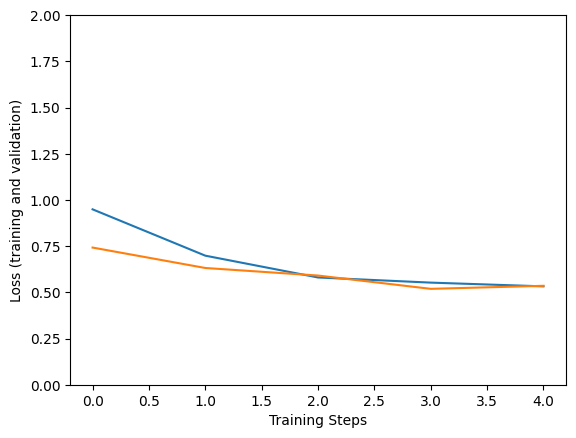

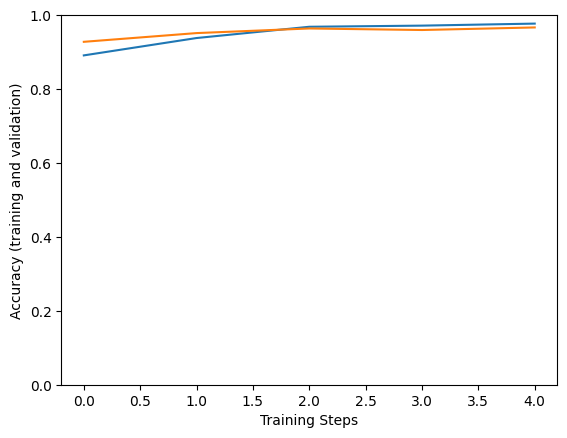

In [10]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

在验证数据中的图像上尝试模型：

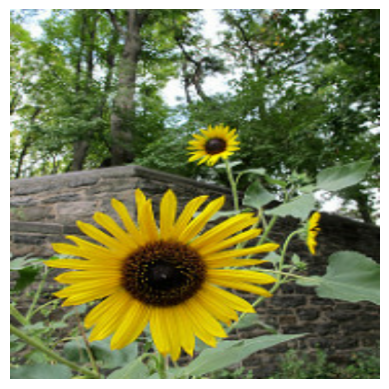

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 5s 5s/step


True label: sunflowers
Predicted label: sunflowers


In [11]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

最后，您可以保存训练的模型，以便部署到 TF Serving 或 TF Lite（在移动设备上），如下所示。

In [12]:
saved_model_path = f"/tmp/saved_flowers_model_{model_name}"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_efficientnetv2-xl-21k/assets


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_efficientnetv2-xl-21k/assets


## 可选：部署到 TensorFlow Lite

[TensorFlow Lite](https://tensorflow.google.cn/lite) 可让您将 TensorFlow 模型部署到移动和 IoT 设备上。下面的代码演示了如何将训练的模型转化为 TF Lite 以及应用 [TensorFlow Model Optimization Toolkit](https://tensorflow.google.cn/model_optimization) 中的训练后工具。最后，它会在 TF Lite Interpreter 中运行模型，以检查结果质量。

- 未使用优化的转换结果与之前相同（由舍入误差决定）。
- 进行了优化但未使用任何数据的转换会将模型权重量化为 8 位，但是，神经网络激活的推理仍使用浮点计算。这会将模型大小减小为约四分之一，同时可以改善移动设备上的 CPU 延迟。
- 最重要的是，如果提供一个小参考数据集来校准量化范围，神经网络激活的计算也可以量化为 8 位整数。在移动设备上，这会进一步加快推断速度，并使其可以在 EdgeTPU 之类的加速器上运行。

In [13]:
#@title Optimization settings
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/lite_flowers_model_{model_name}.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

2022-12-14 21:31:01.185665: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-14 21:31:01.185713: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


Wrote TFLite model of 826217852 bytes.


In [14]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TFLite Interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [15]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TFLite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TFLite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


TFLite model agrees with original model on 50 of 50 examples (100%).
TFLite model is accurate on 50 of 50 examples (100%).
